# Rayleigh-Taylor Instability - Growth-Rate Calculation

Here we quantify the initial growth-rate of a Rayleigh-Taylor Instability, introduced in an earlier [example](https://github.com/underworldcode/underworld2/blob/master/docs/examples/1_06_Rayleigh_Taylor.ipynb).

The model set up is shown below, where we are interested in the development of the perturbation $w$. The upper layer represents cold and subsequently dense (large $\rho$) and strong (large $\mu$) lithosphere (relative to the asthenosphere). We will quantify how quickly an instability with a particular wavelength will develop and compare this to an analytic solution.

<img src="RTI_GrowthRate_Supp/rt.png" alt="Model Setup" style="width: 500px;" align="middle"/>


----

Provided that $w << L$, in other words, the perturbation size is not comparable in magnitude to the dense lithosphere thickness, the following analytic model accurately describes perturbation growth through time:

$ w(t) = w_0 e^{\tau t}$
Here, $w_0$ is $w$ at $t=0$ and $\tau$ is the exponential growth-rate. 

If we find the derivative of $w$:

$\dot{w} = \tau w_0 e^{\tau t}$

(we are using the notation $\dot{w} \equiv \frac{\partial w}{\partial t}$ for convenience.

We can see that:

$\dot{w} = \tau w$

In other words, the velocity grows linearly with the perturbation displacement, depending on $\tau$, which results in the exponential growth.

This relationship must hold at any time (provided $w<<L$), so for a given time,
$\tau = \frac{\dot{w}}{w}$.

We will use this relationship to calculate $\tau$, for a given perturbation frequency.

---

The perturbation frequency is defined as $f = \lambda^{-1}$, where f is frequency and $\lambda$ wavelength.
We use it because the analytic solution is nicely given as a function of the non-dimensional group $k=2\pi f L$, where $L$ is the thickness of the dense lithosphere.

In this notebook, you will enter the number of waves $n$, from which $k = \frac{2\pi n}{12}$, assuming the model domain width is 12 and $L=1$. The growth-rate $\tau$ is already non-dimensionalised, due to our choice of parameters.

We will import an analytic solution stored in ```gr.py```, which gives an exact value of $\tau$ for a given $k$. We are going to use this to check out numerical calculation.

** Extra Reading: **
You can find a simplified derivation of the analytic RTI solution in `Geodynamics' by Turcotte and Schubert, in the fluid dynamics section applied to salt diapirism. 



---



##Step 1. Set up model geometry

In [82]:
# Import things we need
import underworld as uw
import numpy
import glucifer
import matplotlib.pyplot as plt
import mpi4py
import h5py
import os

uw.matplotlib_inline()

comm = mpi4py.MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


outputPath = os.path.join(os.path.abspath("."),"RTI_GrowthRate_Data/")

if uw.rank()==0:

    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.barrier()

In [83]:
# Domain resolution and size
resY = 32
resX = 64

minX=0.0
maxX=12.0
minY=-6.0
maxY=0

elementType = "Q1/dQ0"
mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = (resX, resY), 
                                 minCoord    = (minX, minY), 
                                 maxCoord    = (maxX, maxY)) 


In [84]:
# Define a particle swarm, so we can define and track our materials
mSwarm = uw.swarm.Swarm( mesh=mesh)

# Number of particles per element
nParticles = 12

# Where to put the particles
layout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=mSwarm, particlesPerCell=nParticles )

# A variable to track each material
mIVar = mSwarm.add_variable( dataType="int", count=1)

# Put out particles
mSwarm.populate_using_layout( layout=layout )


##*Here are the important layer geometrical properties*

```perturbation_n``` is the integer number of sinusoidal waves which make up the perturbed interface in our domain. We will change this later on.

These are set as arrays, so that you could have multiple perturbations if you choose to later on.

In [85]:
# Layer geometry 

# Layer thickness
L = 1.

# Perturbation wavenumber, 
#as a reminder k = 2 pi n / 12, so bigger n results in larger frequency or smaller wavelength
perturbation_n = [4]
# Perturbation amplitude
perturbation_a = [5e-2]


In [86]:
# A routine for setting up the perturbed interface.

def InterfaceY(x,arrN,arrA):
    pertX = 0.
    for i in range(len(arrN)):
        pertX += arrA[i] * -uw.function.math.cos(2.*numpy.pi * float(arrN[i]) / (maxX-minX) * x )

    interface = maxY - L + pertX
    
    return interface
        

In [87]:
# Material IDs
asth_id = 0
lith_id = 1

# Set materials
coord = uw.function.input()
material_func = uw.function.branching.conditional([(coord[1] > InterfaceY(coord[0],perturbation_n,perturbation_a),lith_id),(True,asth_id)])
mIVar.data[:] = material_func.evaluate(mSwarm) 

**Plot materials to make sure they are set up correctly**


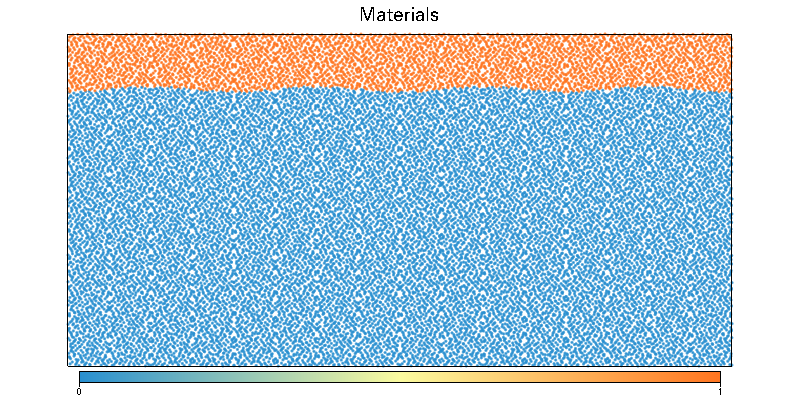

In [88]:
figMaterial = glucifer.Figure( figsize=(800,400), title="Materials" )
figMaterial.append( glucifer.objects.Points(swarm=mSwarm,fn_colour=mIVar,fn_size=4 ))

if size == 1:
    figMaterial.show()


## Step 2. Set up dynamic fields / variables

In [89]:
# Set up fields
pressureField    = mesh.subMesh.add_variable( nodeDofCount=1 )
velocityField    = mesh.add_variable( nodeDofCount=2 )


**Boundary conditions**

For each wall of the domain, we have two options; force the velocity in all directions to be zero (fixed) or allow the velocity to only vary in parallel to the wall (free-slip).

We will set the top wall to be fixed, to mimic the presence of a strong upper crust above the model. Alternatively later on you could change this to free-slip, by setting ```topwall_fixed = False``` below. All other walls are set to free-slip.

In [90]:
topwall_fixed = True

In [91]:
# Set boundary conditions

LeftRightWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
TopBottomWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
TopWall = mesh.specialSets["MaxJ_VertexSet"] 

if topwall_fixed:
    freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              indexSetsPerDof=(LeftRightWalls+TopWall,TopBottomWalls) )
else:
    freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              indexSetsPerDof=(LeftRightWalls,TopBottomWalls) )

**Set up Material Densities**

In [92]:
# Lithospheric and asthenospheric densities
rho_lith = 1.
rho_asth = 0.

dicDensity = {lith_id:rho_lith,asth_id:rho_asth}

# This function returns the density at a point
densityFn = uw.function.branching.map( fn_key = mIVar, 
                         mapping = dicDensity)

# Multiply the density by gravity to give a buoyancy.
#     This buoyancy is what drives flow.
gravity = ( 0.,-1.)
buoyFunc = gravity * densityFn

Plot densities to make sure they look right


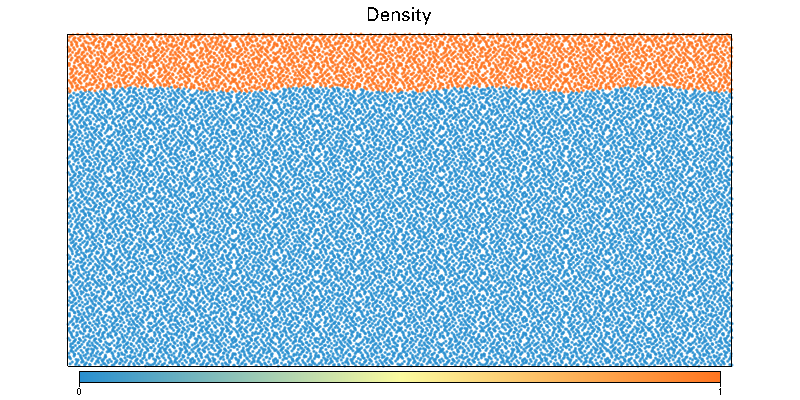

In [93]:
figMaterialDens = glucifer.Figure( figsize=(800,400), title="Density" )
figMaterialDens.append( glucifer.objects.Points(swarm=mSwarm,fn_colour=densityFn,fn_size=4 ))
if size == 1:
    figMaterialDens.show()


**Set up Material Viscosities**

We will initially set the lithosphere viscosity to be $100\times$ stronger than the asthenosphere. We will vary this viscosity later on.

In [94]:
# Lithospheric and asthenospheric viscosities
eta_lith = 1.
eta_asth = 1e-2

dicViscosity = {lith_id:eta_lith,asth_id:eta_asth}

viscosityMapFn = uw.function.branching.map( fn_key = mIVar, 
                         mapping = dicViscosity)


Plot viscosities to make sure they look right. Note the log scale.


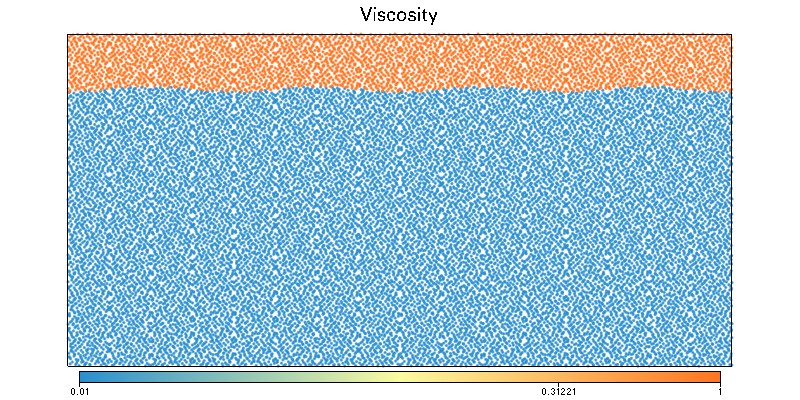

In [95]:
figMaterialVisc = glucifer.Figure( figsize=(800,400), title="Viscosity" )
figMaterialVisc.append( glucifer.objects.Points(swarm=mSwarm,fn_colour=viscosityMapFn,fn_size=4,logScale=True ))
if size == 1:
    figMaterialVisc.show()


## Step 3. Set up equations

In [96]:
# Set up the solver for the Stokes equations
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              fn_viscosity=viscosityMapFn, 
                              fn_bodyforce=buoyFunc,
                             voronoi_swarm=mSwarm)

solver=uw.systems.Solver(stokesPIC)

# Set up advectors, which advect the particles using the calculated velocity field
advector = uw.systems.SwarmAdvector( swarm=mSwarm, velocityField=velocityField, order=2 )


---

## New Step: Set up a marker to track $w$

Pick a horizontal value to place our marker. We'll automatically pick the correct depth so that it is sitting on the perturbation.

In [97]:
# Whick peak to put it on
x_marker = 0. * (maxX-minX) / perturbation_n[0]


In [98]:
markerSwarm = uw.swarm.Swarm( mesh=mesh)
y_marker = InterfaceY(x_marker,perturbation_n,perturbation_a).evaluate()[0][0]

markerSwarm.add_particles_with_coordinates(numpy.array([(x_marker,y_marker)]))
markeradvector = uw.systems.SwarmAdvector( swarm=markerSwarm, velocityField=velocityField, order=2 )



The initial $w$ is:

In [99]:
w0 = -1. * (L+y_marker)
if rank == 0:
    print("w0 = %.4f" %w0)

w0 = 0.0500


Check its position:

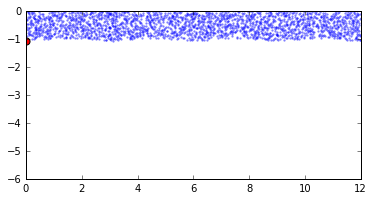

In [100]:
def plotMarker(step):
    plt.clf()
    arrLithI = numpy.where(mIVar.data == lith_id)[0][::2]
    plt.gca().set_aspect('equal')
    plt.xlim(minX,maxX)
    plt.ylim(minY,maxY)
    plt.scatter(mSwarm.particleCoordinates.data[arrLithI,0],mSwarm.particleCoordinates.data[arrLithI,1],alpha=0.5,lw=0,s=5)
    plt.scatter(markerSwarm.particleCoordinates.data[:,0],markerSwarm.particleCoordinates.data[:,1],c='red',s=50)
    plt.savefig(outputPath + 'Marker_%i.pdf' %step)

if size == 1:
    plotMarker(0)

## Step 4. Solve!

Step 0 complete
Step 1 complete
Step 2 complete
Step 3 complete
Step 4 complete
Step 5 complete
Step 6 complete
Step 7 complete
Step 8 complete
Step 9 complete


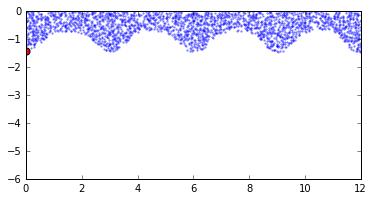

In [101]:
# The number of steps to take
nSteps = 10

# Plot a figure of material distribution and write to file every n steps
nOutputEvery = 1

time = 0.

# Set up arrays for collecting data

if rank == 0:
    fw = open(outputPath + "ParticlePosition.txt","w")
    fw.write("Time \t W \t dWdT \n")
    fw.close()

for i in range(nSteps):
    # Solve Stokes, giving new pressure and velocity fields
    solver.solve()

    # Write data, if this cpu has our tracking particle
    if markerSwarm.particleLocalCount > 0:
        w = -(markerSwarm.particleCoordinates.data[0][1]+L)
        dwdt = -velocityField.evaluate(tuple(markerSwarm.particleCoordinates.data[0]))[0,1]

        fw = open(outputPath + "ParticlePosition.txt","a")

        fw.write("%.4e \t %.4e \t %.4e \n" %(time,w,dwdt))
        fw.close()
    
    # Advect particles
    dt = advector.get_max_dt()*0.5
    time += dt
    advector.integrate(dt)
    markeradvector.integrate(dt)

    #Plot, if neccessary
    if i % nOutputEvery == 0:
        if size == 1:
            plotMarker(i)
        else:
            # It's easier to print using gLucifer in parallel
            figMaterial.save_image(outputPath + 'Materials_%i.png' %i)

            
    if rank == 0:
        print("Step %i complete" %i)
    

# Exercise: Comparison of Numerical and Analytic Solutions

Calculate the exponential growth-rate for a variety of $n$ (number of perturbation waves). You will combine these calculations to form a plot showing how $\tau$ depends on $k$, where $k = \pi n / 6$. An analytic solution exists for this dependence and our specific model setup. Use this to quanitify how accurately our numerical model captures the initial velocity growth from a small perturbation.


Below are our calculated values of $w$ (in arrW), $\dot{w}$ (in arrdWdt) for each time (in arrTime)

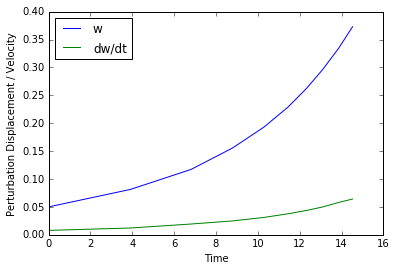

In [102]:
if rank == 0:
    data = numpy.loadtxt(outputPath + "ParticlePosition.txt",skiprows=1)
    arrTime = data[:,0]
    arrW = data[:,1]
    arrdWdt = data[:,2]

    plt.clf()
    plt.plot(arrTime,arrW,label='w')
    plt.plot(arrTime,arrdWdt,label='dw/dt')
    plt.xlabel('Time')
    plt.ylabel('Perturbation Displacement / Velocity')
    plt.legend(loc=2)
    
    plt.savefig(outputPath + 'VelocityDisplacementTime.pdf')

Here we will calculate $\tau$ at each time-step, using the relationship $\tau = \frac{\dot{w}}{w}$

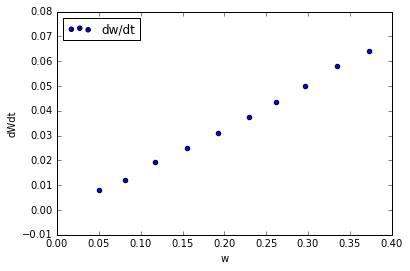

In [103]:
if rank == 0:
    plt.clf()
    plt.scatter(arrW,arrdWdt,label='dw/dt')
    plt.xlabel('w')
    plt.ylabel('dWdt')
    plt.legend(loc=2)
    
    plt.savefig(outputPath + 'VelocityDisplacement.pdf')

If the scatter plot above is significantly non-linear, you have entered the super-exponential phase and you need to only use the linear points. Should not be a problem unless you alter domain / resolution settings.

In [104]:
if rank == 0:
    arrTau = arrdWdt / arrW

    # k = 2 * pi * n / (domain width)
    k = 2. * numpy.pi * perturbation_n[0] / 12.
    print("Tau at each time: ")
    print(arrTau)

    avTau = numpy.average(arrTau)
    print("Average Tau is %.2e" %avTau)




Tau at each time: 
[ 0.157776    0.14976522  0.16491423  0.15971436  0.16135657  0.16449206
  0.16625959  0.16855552  0.17347817  0.17185145]
Average Tau is 1.64e-01


The following analytic solution is eq. 39, from *'The growth of Rayleigh-Taylor-type instabilities in the lithosphere for various rheological and density structures'*, Conrad and Molnar (1997):

In [105]:
def analytic_growthrate(k):
    q = (numpy.cosh(k) * numpy.sinh(k) - k)/(k**2. + numpy.cosh(k)**2.) / (2.*k)
    return q

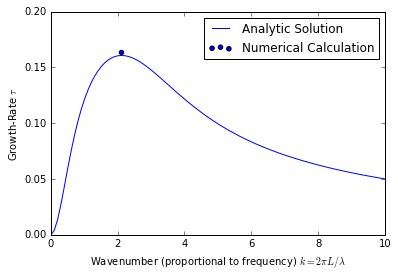

In [106]:
#Analytic Solution

if rank == 0:
    plt.clf()
    
    # The solution is undefined at 0, so start at 0.01
    arrK = numpy.linspace(0.01,10,100)
    arrATau = numpy.zeros(len(arrK))
    plt.xlim(0,10)
    plt.ylim(0,0.2)
    for i in range(len(arrK)):
        arrATau[i] = analytic_growthrate(arrK[i])

    plt.plot(arrK,arrATau,label="Analytic Solution")
    plt.scatter(k,avTau,label="Numerical Calculation")
    plt.legend()

    plt.xlabel('Wavenumber (proportional to frequency) ' + r'$k = 2 \pi L / \lambda$')
    plt.ylabel('Growth-Rate ' + r'$\tau$')
    
    plt.savefig(outputPath + 'GrowthRate_Benchmark.pdf')

**Benchmark**

The comparison between the analytic prediction plotted above and the numerical solution can be used to quantify the accuracy of our Rayleigh-Taylor solution for the initial growth period:

In [107]:
if rank == 0:
    grAn = analytic_growthrate(k)
    err = abs(avTau - grAn) / grAn
    print("Numerical solution is accurate to %.2f percent" %(err*100))


Numerical solution is accurate to 1.95 percent


*Even the low default resolution, this should be reasonably accurate. Notice how the accuracy reduces for a smaller initial perturbation, especially if you switch of vornoi integration. It is also going to be sensitive to the mesh edge positions relative to the interface and the time-step size.*

----

## Application Example

The initial growth of a RTI can be described as $w(t) = w_0 e^{\tau t}$. You have already gathered the information you need for applying this to the lithosphere.


So far we have been using non-dimensional units. This has been so we can apply these simple models to a variety of situations.
You can convert these back by assuming by plugging in values for $\Delta\rho = \rho_1 - \rho_0$, the viscosity of the lithosphere $\eta$, gravity $g$ and the initial perturbation $w_0$:

$w = w_0 e^{\frac{\Delta\rho g L}{\eta}\tau t}$

The time taken to reach $w_0 = L$ (doubling of thickness) is:

$ t = log_e\left(\frac{L}{w_0}\right)\frac{\eta}{\Delta\rho g L \tau} $

You will need to be very careful that your units are consistent!

Let's model a dense lithosphere which is $50\ km$ thick and an intial perturbation of $5\ km$. It is $30\ kg\ m^{-3}$ denser than the asthenosphere and has a viscosity of $10^{21}\ Pa\ s$.

** Question**

For your fastest calculated $\tau$ above, how long will it take for the lithosphere to double in thickness?

